In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import shap
import socket
import matplotlib.pyplot as plt
from tqdm import tqdm

d:\Prog\iomt-anomalyze\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
import seaborn as sns
import os
import gc
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [6]:
df = pd.read_csv("../data/raw/CIC_IoMT_2024_WiFi_MQTT_train.csv")

In [7]:
label_mapping = {
    'Benign': ['Benign_train'],
    
    'Spoofing': ['ARP_Spoofing_train'],

    'Reconnaissance': [
        'Recon-OS_Scan_train',
        'Recon-Ping_Sweep_train',
        'Recon-VulScan_train',
        'Recon-Port_Scan_train'
    ],
    
    'MQTT': [
        'MQTT-Malformed_Data_train',
        'MQTT-DoS-Connect_Flood_train',
        'MQTT-DDoS-Publish_Flood_train',
        'MQTT-DoS-Publish_Flood_train',
        'MQTT-DDoS-Connect_Flood_train'
    ],

    'DoS': [
        'TCP_IP-DoS-TCP1_train', 'TCP_IP-DoS-TCP2_train', 'TCP_IP-DoS-TCP3_train', 'TCP_IP-DoS-TCP4_train',
        'TCP_IP-DoS-UDP1_train', 'TCP_IP-DoS-UDP2_train', 'TCP_IP-DoS-UDP3_train', 'TCP_IP-DoS-UDP4_train',
        'TCP_IP-DoS-ICMP1_train', 'TCP_IP-DoS-ICMP2_train', 'TCP_IP-DoS-ICMP3_train', 'TCP_IP-DoS-ICMP4_train',
        'TCP_IP-DoS-SYN1_train', 'TCP_IP-DoS-SYN2_train', 'TCP_IP-DoS-SYN3_train', 'TCP_IP-DoS-SYN4_train'
    ],

    'DDoS': [
        'TCP_IP-DDoS-TCP1_train', 'TCP_IP-DDoS-TCP2_train', 'TCP_IP-DDoS-TCP3_train', 'TCP_IP-DDoS-TCP4_train',
        'TCP_IP-DDoS-UDP1_train', 'TCP_IP-DDoS-UDP2_train', 'TCP_IP-DDoS-UDP3_train', 'TCP_IP-DDoS-UDP4_train',
        'TCP_IP-DDoS-UDP5_train', 'TCP_IP-DDoS-UDP6_train', 'TCP_IP-DDoS-UDP7_train', 'TCP_IP-DDoS-UDP8_train',
        'TCP_IP-DDoS-ICMP1_train', 'TCP_IP-DDoS-ICMP2_train', 'TCP_IP-DDoS-ICMP3_train', 'TCP_IP-DDoS-ICMP4_train',
        'TCP_IP-DDoS-ICMP5_train', 'TCP_IP-DDoS-ICMP6_train', 'TCP_IP-DDoS-ICMP7_train', 'TCP_IP-DDoS-ICMP8_train',
        'TCP_IP-DDoS-SYN1_train', 'TCP_IP-DDoS-SYN2_train', 'TCP_IP-DDoS-SYN3_train', 'TCP_IP-DDoS-SYN4_train'
    ]
}

In [8]:
def map_category(label):
    for parent, sub_labels in label_mapping.items():
        if label in sub_labels:
            return parent
    return 'Unknown'
df['SuperClass'] = df['label'].apply(map_category)

In [9]:
grouped = df.groupby(['SuperClass', 'label']).size().reset_index(name='Records')
total = len(df)
grouped['Percentage'] = (grouped['Records'] / total) * 100

summary = grouped.groupby('SuperClass')['Records'].sum().reset_index()
summary['Percentage'] = (summary['Records'] / total) * 100

print("Hierarchical Breakdown:")
display(grouped.sort_values(['SuperClass', 'Records'], ascending=[True, False]).head(20))

print("Category Summary:")
display(summary)

Hierarchical Breakdown:


,SuperClass,label,Records,Percentage
0,Benign,Benign_train,192732,2.691475
18,DDoS,TCP_IP-DDoS-UDP2_train,207295,2.894846
19,DDoS,TCP_IP-DDoS-UDP3_train,206604,2.885196
20,DDoS,TCP_IP-DDoS-UDP4_train,206343,2.881551
17,DDoS,TCP_IP-DDoS-UDP1_train,206170,2.879135
21,DDoS,TCP_IP-DDoS-UDP5_train,205507,2.869876
24,DDoS,TCP_IP-DDoS-UDP8_train,204105,2.850298
15,DDoS,TCP_IP-DDoS-TCP3_train,204075,2.849879
10,DDoS,TCP_IP-DDoS-SYN2_train,203669,2.844209
13,DDoS,TCP_IP-DDoS-TCP1_train,202311,2.825245


Category Summary:


,SuperClass,Records,Percentage
0,Benign,192732,2.691475
1,DDoS,4779859,66.750060
2,DoS,1805529,25.213959
3,MQTT,262938,3.671892
4,Reconnaissance,103726,1.448519
5,Spoofing,16047,0.224094


In [10]:
ID_COLS = ['label', 'SuperClass']

In [11]:
DROP_COLS = ['Boot_Time_with_date', 'RTime', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'IMEI']

In [12]:
RATE_COLS = ['Rate', 'Srate', 'Drate'] 

In [13]:
TARGET_COUNTS = {
    'DDoS': 500_000,
    'DoS':  500_000,
    'Benign': 300_000,
    'MQTT': 300_000,
    'Reconnaissance': 200_000,
    'Spoofing': 200_000
}

In [14]:
cols_to_drop = [c for c in DROP_COLS if c in df.columns]
if cols_to_drop:
    print("Dropping ID/time columns:", cols_to_drop)
    df = df.drop(columns=cols_to_drop)

In [15]:
df.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label,SuperClass
0,683.50,17.00,64.0,553148.440,553148.440,0,0.0,0.0,0.0,0.00,...,50.00,101635944.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train,DDoS
1,1745.92,16.12,64.0,29919.545,29919.545,0,0.0,0.0,0.0,0.04,...,52.28,84696616.0,9.5,10.05,2.152,11.785338,0.23,141.5,TCP_IP-DDoS-UDP2_train,DDoS
2,2830.36,15.79,64.0,27075.605,27075.605,0,0.0,0.0,0.0,0.06,...,53.25,84696616.0,9.5,10.35,10.555,113.675460,0.53,141.5,TCP_IP-DDoS-UDP2_train,DDoS
3,4087.50,16.89,64.0,19660.156,19660.156,0,0.0,0.0,0.0,0.00,...,50.16,84696616.0,9.5,10.03,1.236,4.490081,0.18,141.5,TCP_IP-DDoS-UDP2_train,DDoS
4,3916.00,17.00,64.0,270322.780,270322.780,0,0.0,0.0,0.0,0.00,...,50.00,84696616.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train,DDoS


In [16]:
df['SuperClass'].value_counts()

SuperClass
DDoS              4779859
DoS               1805529
MQTT               262938
Benign             192732
Reconnaissance     103726
Spoofing            16047
Name: count, dtype: int64

In [17]:
feature_cols = [c for c in df.columns if c not in ID_COLS]
print(f"Feature count: {len(feature_cols)}")

X_raw = df[feature_cols].copy()
y_raw = df['SuperClass'].copy()

Feature count: 45


In [18]:
non_numeric = [c for c in X_raw.columns if not np.issubdtype(X_raw[c].dtype, np.number)]
if non_numeric:
    print("Non-numeric columns detected - converting to numeric (if possible) or dropping:", non_numeric)
    for c in non_numeric:
        X_raw[c] = pd.to_numeric(X_raw[c], errors='coerce')
    non_numeric_after = [c for c in X_raw.columns if not np.issubdtype(X_raw[c].dtype, np.number)]
    if non_numeric_after:
        print("Dropping columns still non-numeric:", non_numeric_after)
        X_raw = X_raw.drop(columns=non_numeric_after)

In [19]:
rate_cols_present = [c for c in RATE_COLS if c in X_raw.columns]
if rate_cols_present:
    print("Applying MinMax normalization to rate cols:", rate_cols_present)
    mms = MinMaxScaler()
    X_raw[rate_cols_present] = mms.fit_transform(X_raw[rate_cols_present])

Applying MinMax normalization to rate cols: ['Rate', 'Srate', 'Drate']


In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
del X_raw
gc.collect()

0

In [21]:
X_scaled.shape

(7160831, 45)

In [22]:
y_raw.shape

(7160831,)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

In [ ]:
import numpy as np
import pandas as pd

def hybrid_balance_safe(df, label_col='SuperClass', target_n=60000, random_state=42):
    np.random.seed(random_state)
    balanced_parts = []
    num_cols = [c for c in df.columns if c not in ['label', label_col]]

    for cls, group in df.groupby(label_col):
        n_avail = len(group)
        print(f"Class {cls} -> available: {n_avail}")

        if n_avail > target_n:
            # Downsample
            sampled = group.sample(n=target_n, random_state=random_state)

        elif n_avail == target_n:
            sampled = group

        elif n_avail >= 5:
            # Gaussian noise augmentation for numeric features
            X = group[num_cols].copy()
            n_to_gen = target_n - n_avail

            # Compute per-column stds and add jitter
            stds = X.std(axis=0, ddof=0).replace(0, 1e-6)
            synth_samples = X.sample(n=n_to_gen, replace=True, random_state=random_state)
            noise = np.random.normal(0, 0.01, synth_samples.shape) * stds.values
            synth_samples = synth_samples + noise

            synth_df = synth_samples.copy()
            synth_df[label_col] = cls
            synth_df['label'] = group['label'].sample(
                n=n_to_gen, replace=True, random_state=random_state
            ).values

            sampled = pd.concat([group, synth_df], ignore_index=True)

        else:
            # Tiny class — replicate with replacement
            sampled = group.sample(n=target_n, replace=True, random_state=random_state)

        balanced_parts.append(sampled)

    balanced_df = (
        pd.concat(balanced_parts)
        .sample(frac=1, random_state=random_state)
        .reset_index(drop=True)
    )

    print("\n✅ Done! New distribution:")
    print(balanced_df[label_col].value_counts())
    return balanced_df

In [25]:
subset_df = hybrid_balance_safe(df, label_col='SuperClass', target_n=16047)

Class Benign -> available: 192732
Class DDoS -> available: 4779859
Class DoS -> available: 1805529
Class MQTT -> available: 262938
Class Reconnaissance -> available: 103726
Class Spoofing -> available: 16047

✅ Done! New distribution:
SuperClass
Spoofing          16047
Benign            16047
DDoS              16047
Reconnaissance    16047
DoS               16047
MQTT              16047
Name: count, dtype: int64


In [26]:
subset_df.duplicated().sum()

np.int64(25016)

In [27]:
X = subset_df.drop(columns=['label','SuperClass'], errors='ignore')
y = subset_df['SuperClass']
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.98      0.97      0.97      3209
          DDoS       1.00      1.00      1.00      3209
           DoS       1.00      1.00      1.00      3210
          MQTT       1.00      0.99      1.00      3210
Reconnaissance       1.00      0.99      0.99      3210
      Spoofing       0.96      0.99      0.97      3209

      accuracy                           0.99     19257
     macro avg       0.99      0.99      0.99     19257
  weighted avg       0.99      0.99      0.99     19257



In [28]:
# Combine features and labels
df_combined = pd.concat([X, y], axis=1)

df_combined = df_combined.drop_duplicates()

X_subset = df_combined.drop("SuperClass", axis=1)
y_subset = df_combined["SuperClass"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, stratify=y_subset, test_size=0.2, random_state=42
)


In [29]:
print(X_train.duplicated().sum(), X_test.duplicated().sum())

0 0


In [30]:
X_train.shape

(57012, 45)

In [31]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

In [32]:
X_train_scaledd = scaler.fit_transform(X_train)
X_test_scaledd = scaler.transform(X_test)

In [33]:
X_train_scaled = X_train_scaledd[..., np.newaxis]
X_test_scaled = X_test_scaledd[..., np.newaxis]

In [34]:
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.97      0.97      0.97      3210
          DDoS       1.00      1.00      1.00      1893
           DoS       1.00      1.00      1.00      1947
          MQTT       1.00      0.99      0.99      3209
Reconnaissance       0.99      0.96      0.98      1978
      Spoofing       0.92      0.97      0.94      2017

      accuracy                           0.98     14254
     macro avg       0.98      0.98      0.98     14254
  weighted avg       0.98      0.98      0.98     14254



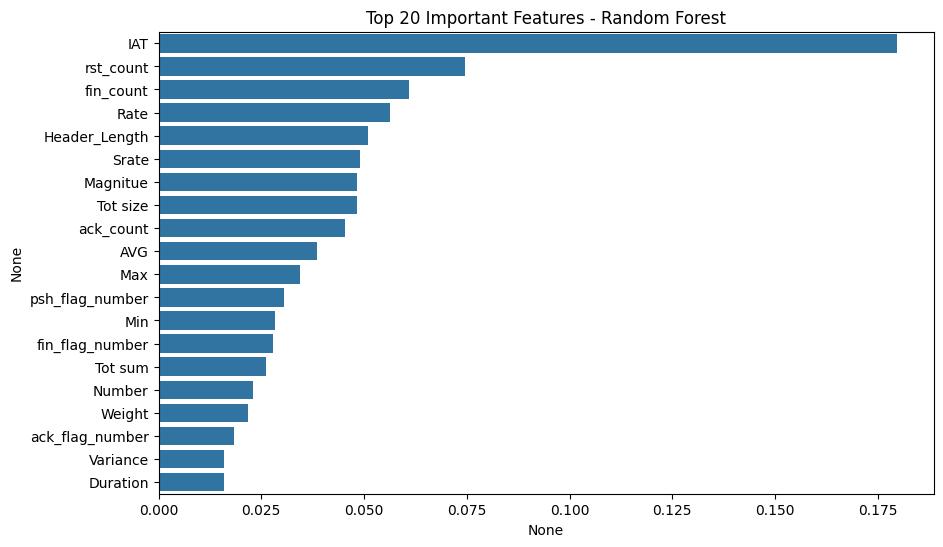

In [35]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:20], y=feat_imp.index[:20])
plt.title("Top 20 Important Features - Random Forest")
plt.show()

In [36]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=4
)


In [37]:
xgb_clf.fit(X_train_scaledd, y_train_enc)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [38]:
y_pred = xgb_clf.predict(X_test_scaledd)

In [39]:
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.97      0.97      0.97      3210
          DDoS       1.00      1.00      1.00      1893
           DoS       1.00      1.00      1.00      1947
          MQTT       1.00      0.99      1.00      3209
Reconnaissance       1.00      0.96      0.98      1978
      Spoofing       0.93      0.97      0.95      2017

      accuracy                           0.98     14254
     macro avg       0.98      0.98      0.98     14254
  weighted avg       0.98      0.98      0.98     14254



In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [41]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

In [42]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [43]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [44]:
class OneDCNN(nn.Module):
    def __init__(self, input_len, num_classes):
        super(OneDCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.global_pool = nn.AdaptiveMaxPool1d(1)   # replaces GlobalMaxPooling1D
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, channels) → need to permute for Conv1d
        x = x.permute(0, 2, 1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x 

In [45]:
input_len = X_train_scaled.shape[1]
model = OneDCNN(input_len, num_classes).to(device)
print(model)

OneDCNN(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (global_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [47]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [48]:
num_epochs = 50

In [49]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []  # <-- added

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)

            # record loss
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)

            _, predicted = torch.max(outputs, 1)
            val_total += y_val.size(0)
            val_correct += (predicted == y_val).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    val_loss /= val_total
    val_acc = val_correct / val_total

    # extra metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store metrics
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")


Epoch [1/50] - Train Loss: 1.0598, Train Acc: 0.6342 | Val Loss: 0.6125, Val Acc: 0.7643 | F1: 0.7425
Epoch [2/50] - Train Loss: 0.5580, Train Acc: 0.7686 | Val Loss: 0.4889, Val Acc: 0.7954 | F1: 0.7699
Epoch [3/50] - Train Loss: 0.4740, Train Acc: 0.7894 | Val Loss: 0.4445, Val Acc: 0.8009 | F1: 0.7710
Epoch [4/50] - Train Loss: 0.4442, Train Acc: 0.7929 | Val Loss: 0.4073, Val Acc: 0.8142 | F1: 0.7904
Epoch [5/50] - Train Loss: 0.4141, Train Acc: 0.8018 | Val Loss: 0.3887, Val Acc: 0.8106 | F1: 0.7849
Epoch [6/50] - Train Loss: 0.4014, Train Acc: 0.8037 | Val Loss: 0.3889, Val Acc: 0.8196 | F1: 0.7961
Epoch [7/50] - Train Loss: 0.3930, Train Acc: 0.8085 | Val Loss: 0.3835, Val Acc: 0.8263 | F1: 0.8047
Epoch [8/50] - Train Loss: 0.3852, Train Acc: 0.8152 | Val Loss: 0.3785, Val Acc: 0.8240 | F1: 0.7931
Epoch [9/50] - Train Loss: 0.3796, Train Acc: 0.8153 | Val Loss: 0.3682, Val Acc: 0.8282 | F1: 0.8018
Epoch [10/50] - Train Loss: 0.3713, Train Acc: 0.8204 | Val Loss: 0.3638, Val Acc:

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9391    0.8262    0.8790      3210
           1     0.7057    0.5543    0.6209      2773
           2     0.6520    0.7806    0.7105      2962
           3     0.9934    0.9829    0.9881      3209
           4     0.9940    0.9199    0.9555      3059
           5     0.7925    0.9557    0.8665      3202

    accuracy                         0.8433     18415
   macro avg     0.8461    0.8366    0.8368     18415
weighted avg     0.8509    0.8433    0.8426     18415



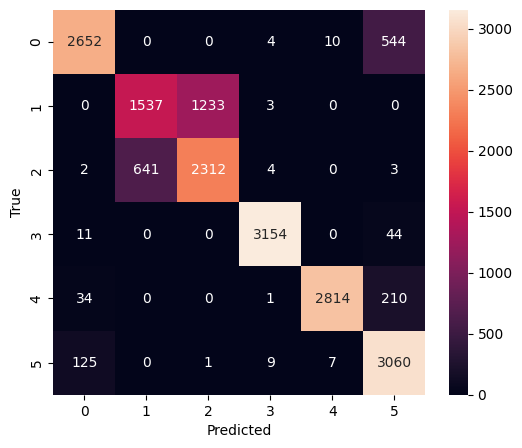

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
history

{'epoch': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 'train_loss': [1.006181026379658,
  0.5355116548358305,
  0.4683812761179555,
  0.4359616479288697,
  0.42007416228764594,
  0.41006220854229514,
  0.4016155258981083,
  0.39416676808515094,
  0.3905122169728691,
  0.3837150125613722,
  0.3811459227995453,
  0.37681286478836273,
  0.3730903734004696,
  0.37025936945527166,
  0.36740126834745895,
  0.36506109496261413,
  0.3602267984869219,
  0.3601785000465142,
  0.35754964768169606,
  0.3543814165403033,
  0.3568707329921212,
  0.35082800361907446,
  0.3525713550225222,
  0.3499981082862373,
  0.34697423825039597,
  0.34529152905825455,
  0.3421858759528313,
  0.3425966167834163,
  0.3400375117924876,
  0.3425918323984167,
  0.33925754249

In [ ]:
df = pd.DataFrame(history)

In [ ]:
df.to_csv("../metrics/torch/1dcnn.csv", index=False)

In [ ]:
torch.save(model.state_dict(), "../artifacts/torch/onedcnn_model_cuda.pth")

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_len, num_classes):
        super(CNN_LSTM, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
    
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        
        self.fc1 = nn.Linear(64, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Input x: (batch, seq_len, 1)
        x = x.permute(0, 2, 1)                   # → (batch, 1, seq_len)
        x = torch.relu(self.bn1(self.conv1(x)))  # (batch, 64, L-2)
        x = torch.relu(self.conv2(x))            # (batch, 128, L-4)
        x = self.pool(x)                         # (batch, 128, (L-4)//2)
        
        # LSTM expects (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        x = h_n[-1]                              # take last hidden state (batch, 64)
        
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x 

In [ ]:
input_len = X_train_scaled.shape[1]
model = CNN_LSTM(input_len, num_classes).to(device)
print(model)

CNN_LSTM(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(128, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        total += y_batch.size(0)
        train_correct += (preds == y_batch).sum().item()
    
    avg_train_loss = train_loss / total
    train_acc = train_correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []   # <-- NEW

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            
            # collect validation loss
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)

            _, preds = torch.max(outputs, 1)
            val_total += y_val.size(0)
            val_correct += (preds == y_val).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Compute metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)     # <-- (fix) store avg, not sum
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(avg_val_loss)         # <-- NEW
    history["precision"].append(precision)           # <-- NEW
    history["recall"].append(recall)                 # <-- NEW
    history["f1"].append(f1)                         # <-- NEW

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")


Epoch [1/50] | Train Loss: 0.8162, Train Acc: 0.6550 | Val Loss: 0.4652, Val Acc: 0.7660 | F1: 0.7590
Epoch [2/50] | Train Loss: 0.4700, Train Acc: 0.7652 | Val Loss: 0.4221, Val Acc: 0.7826 | F1: 0.7759
Epoch [3/50] | Train Loss: 0.4230, Train Acc: 0.7842 | Val Loss: 0.4146, Val Acc: 0.7806 | F1: 0.7672
Epoch [4/50] | Train Loss: 0.4125, Train Acc: 0.7879 | Val Loss: 0.3926, Val Acc: 0.8043 | F1: 0.7981
Epoch [5/50] | Train Loss: 0.3953, Train Acc: 0.7978 | Val Loss: 0.3795, Val Acc: 0.8003 | F1: 0.7778
Epoch [6/50] | Train Loss: 0.3828, Train Acc: 0.8062 | Val Loss: 0.3789, Val Acc: 0.8151 | F1: 0.8074
Epoch [7/50] | Train Loss: 0.3729, Train Acc: 0.8148 | Val Loss: 0.3649, Val Acc: 0.8200 | F1: 0.8116
Epoch [8/50] | Train Loss: 0.3666, Train Acc: 0.8180 | Val Loss: 0.3650, Val Acc: 0.8226 | F1: 0.8168
Epoch [9/50] | Train Loss: 0.3632, Train Acc: 0.8207 | Val Loss: 0.3614, Val Acc: 0.8238 | F1: 0.8129
Epoch [10/50] | Train Loss: 0.3586, Train Acc: 0.8250 | Val Loss: 0.3466, Val Acc:

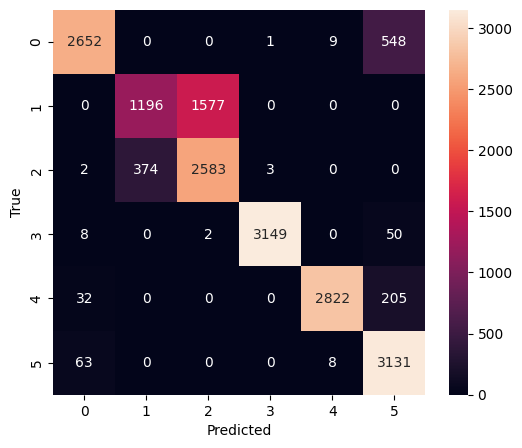

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9619    0.8262    0.8889      3210
           1     0.7618    0.4313    0.5508      2773
           2     0.6206    0.8720    0.7252      2962
           3     0.9987    0.9813    0.9899      3209
           4     0.9940    0.9225    0.9569      3059
           5     0.7959    0.9778    0.8775      3202

    accuracy                         0.8435     18415
   macro avg     0.8555    0.8352    0.8315     18415
weighted avg     0.8598    0.8435    0.8386     18415



In [ ]:
df = pd.DataFrame(history)

In [ ]:
df.to_csv("../metrics/torch/rclnet.csv", index=False)

In [ ]:
torch.save(model.state_dict(), "../artifacts/torch/rclnet_cuda.pth")

In [ ]:
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_len, num_classes, lstm_hidden=64, num_heads=4):
        super(CNN_BiLSTM_Attention, self).__init__()
        
        # CNN feature extractor
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding='same')
        self.pool = nn.MaxPool1d(2)
        
        # BiLSTM block
        self.bilstm = nn.LSTM(
            input_size=128,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        # Multi-Head Self-Attention
        self.attention = nn.MultiheadAttention(embed_dim=2*lstm_hidden, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(2*lstm_hidden)

        # Dense layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(2*lstm_hidden, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Input shape: (batch, seq_len, 1)
        x = x.permute(0, 2, 1)                 # (batch, 1, seq_len)
        x = torch.relu(self.conv1(x))          # (batch, 64, seq_len)
        x = torch.relu(self.conv2(x))          # (batch, 128, seq_len)
        x = self.pool(x)                       # (batch, 128, seq_len//2)
        
        # Prepare for LSTM: (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        x, _ = self.bilstm(x)                  # (batch, seq_len//2, 2*lstm_hidden)
        
        # Multihead Self-Attention with residual connection
        attn_output, _ = self.attention(x, x, x)
        x = self.norm(x + attn_output)

        # Global average pooling over the sequence dimension
        x = x.permute(0, 2, 1)
        x = self.global_pool(x).squeeze(-1)    # (batch, 2*lstm_hidden)
        
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)                        # logits
        return x


In [ ]:
input_len = X_train_scaled.shape[1]
model = CNN_BiLSTM_Attention(input_len, num_classes).to(device)
print(model)

CNN_BiLSTM_Attention(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=same)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bilstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        total += y_batch.size(0)
        train_correct += (preds == y_batch).sum().item()
    
    avg_train_loss = train_loss / total
    train_acc = train_correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)

            val_loss += loss.item() * X_val.size(0)
            _, preds = torch.max(outputs, 1)

            val_total += y_val.size(0)
            val_correct += (preds == y_val).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Compute metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store all of them
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")

Epoch [1/50] | Train Loss: 0.7620 | Train Acc: 0.6604 | Val Loss: 0.4588 | Val Acc: 0.7751 | F1: 0.7702
Epoch [2/50] | Train Loss: 0.4461 | Train Acc: 0.7745 | Val Loss: 0.4112 | Val Acc: 0.7844 | F1: 0.7773
Epoch [3/50] | Train Loss: 0.4125 | Train Acc: 0.7845 | Val Loss: 0.4009 | Val Acc: 0.7904 | F1: 0.7832
Epoch [4/50] | Train Loss: 0.4047 | Train Acc: 0.7916 | Val Loss: 0.3858 | Val Acc: 0.8026 | F1: 0.7970
Epoch [5/50] | Train Loss: 0.4144 | Train Acc: 0.7967 | Val Loss: 0.4135 | Val Acc: 0.7824 | F1: 0.7639
Epoch [6/50] | Train Loss: 0.3847 | Train Acc: 0.8105 | Val Loss: 0.3742 | Val Acc: 0.8111 | F1: 0.8040


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9286    0.9043    0.9163      6000
           1     0.7310    0.5816    0.6478      4948
           2     0.6742    0.8022    0.7327      5359
           3     0.9971    0.9872    0.9921      6000
           4     0.9925    0.9191    0.9544      5589
           5     0.8604    0.9499    0.9029      5993

    accuracy                         0.8662     33889
   macro avg     0.8640    0.8574    0.8577     33889
weighted avg     0.8701    0.8662    0.8654     33889



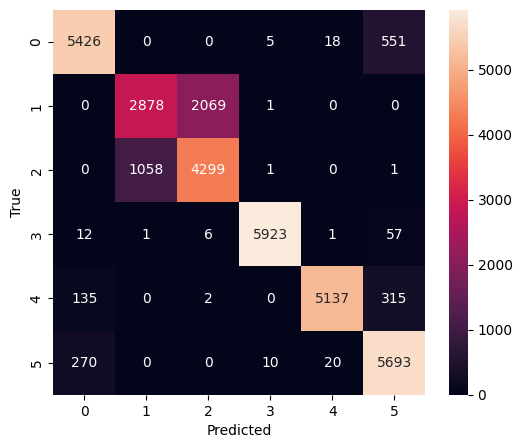

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
df = pd.DataFrame(history)
df.to_csv("../metrics/torch/rclnet-attn.csv", index=False)
torch.save(model.state_dict(), "../artifacts/torch/rclnet-attn_cuda.pth")

In [ ]:
import torch.nn.functional as F

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


# -------------------------------
# Residual Conv1D Block
# -------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding="same")
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding="same")
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels else nn.Identity()
        )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out


# -------------------------------
# Advanced Residual + BiLSTM + Attention Model
# -------------------------------
class RCLNet_Attn_Pro(nn.Module):
    def __init__(self, input_features, num_classes, max_len=None):
        super(RCLNet_Attn_Pro, self).__init__()
        self.use_pos_enc = max_len is not None
        if self.use_pos_enc:
            self.pos_enc = PositionalEncoding(d_model=input_features, max_len=max_len)

        # CNN residual encoder
        self.res1 = ResidualBlock(1, 64)
        self.res2 = ResidualBlock(64, 128)
        self.pool = nn.MaxPool1d(2)

        # BiLSTM + MultiHeadAttention
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True, bidirectional=True)
        self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=4, dropout=0.2, batch_first=True)
        self.norm = nn.LayerNorm(128)

        # Dense classifier
        self.fc1 = nn.Linear(128, 256)
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Input: (batch, seq_len, features)
        if self.use_pos_enc:
            x = self.pos_enc(x)

        # CNN expects (batch, channels, seq_len)
        x = x.permute(0, 2, 1)  # (B, F, T)
        x = self.res1(x)
        x = self.res2(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # (B, T, F)

        # BiLSTM + MultiHeadAttention
        x, _ = self.lstm(x)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm(x + attn_out)

        # Global average pooling (mean over sequence)
        x = x.mean(dim=1)

        # Dense classifier
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
if X_train_t.dim() == 4:
    X_train_t = X_train_t.squeeze(-1)
elif X_train_t.dim() == 2:
    X_train_t = X_train_t.unsqueeze(-1)

y_train_t = torch.tensor(y_train_enc, dtype=torch.long)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
if X_test_t.dim() == 4:
    X_test_t = X_test_t.squeeze(-1)
elif X_test_t.dim() == 2:
    X_test_t = X_test_t.unsqueeze(-1)

y_test_t = torch.tensor(y_test_enc, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

In [ ]:
input_features = 1              # last dim from (seq_len, features)
seq_len = X_train_scaled.shape[1]
num_classes = len(le.classes_)

In [ ]:
model = RCLNet_Attn_Pro(input_features, num_classes, max_len=seq_len).to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

0.296006 M parameters


In [ ]:
dummy = torch.randn(8, seq_len, input_features).to(device)
out = model(dummy)
print(out.shape)

torch.Size([8, 6])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
seq_len = X_train_scaled.shape[1]
num_classes = len(le.classes_)

In [ ]:
model = RCLNet_Attn_Pro(input_features=1, num_classes=num_classes, max_len=seq_len).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [ ]:
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []     # NEW

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)

            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= val_total
    val_acc = val_correct / val_total

    # Extra Metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store metrics
    history["epoch"].append(epoch+1)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")

Epoch [1/50] | Train Loss: 0.3838, Train Acc: 0.8028 | Val Loss: 0.3441, Val Acc: 0.8192 | F1: 0.8027
Epoch [2/50] | Train Loss: 0.3333, Train Acc: 0.8322 | Val Loss: 0.3124, Val Acc: 0.8448 | F1: 0.8347
Epoch [3/50] | Train Loss: 0.3162, Train Acc: 0.8406 | Val Loss: 0.3111, Val Acc: 0.8512 | F1: 0.8440
Epoch [4/50] | Train Loss: 0.3090, Train Acc: 0.8460 | Val Loss: 0.2922, Val Acc: 0.8563 | F1: 0.8491
Epoch [5/50] | Train Loss: 0.3039, Train Acc: 0.8481 | Val Loss: 0.2927, Val Acc: 0.8543 | F1: 0.8410
Epoch [6/50] | Train Loss: 0.2962, Train Acc: 0.8514 | Val Loss: 0.2971, Val Acc: 0.8443 | F1: 0.8305
Epoch [7/50] | Train Loss: 0.2928, Train Acc: 0.8534 | Val Loss: 0.3025, Val Acc: 0.8507 | F1: 0.8369
Epoch [8/50] | Train Loss: 0.2889, Train Acc: 0.8562 | Val Loss: 0.2882, Val Acc: 0.8609 | F1: 0.8533
Epoch [9/50] | Train Loss: 0.2860, Train Acc: 0.8569 | Val Loss: 0.2816, Val Acc: 0.8621 | F1: 0.8546
Epoch [10/50] | Train Loss: 0.2845, Train Acc: 0.8583 | Val Loss: 0.2796, Val Acc:

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9381    0.8993    0.9183      6000
           1     0.7903    0.5073    0.6179      4948
           2     0.6582    0.8752    0.7513      5359
           3     0.9906    0.9888    0.9897      6000
           4     0.9841    0.9288    0.9556      5589
           5     0.8687    0.9524    0.9086      5993

    accuracy                         0.8684     33889
   macro avg     0.8717    0.8586    0.8569     33889
weighted avg     0.8769    0.8684    0.8651     33889



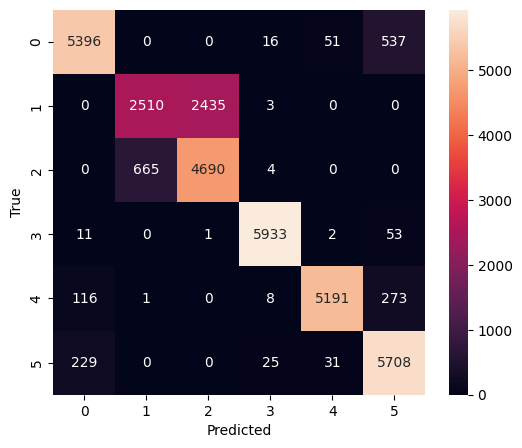

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
df = pd.DataFrame(history)
df.to_csv("../metrics/torch/rclnet-multiheadselfattn.csv", index=False)
torch.save(model.state_dict(), "../artifacts/torch/rclnet-MULTI_cuda.pth")